# P2 Diffusion model for Conditional Image Generation on MNIST (30%)

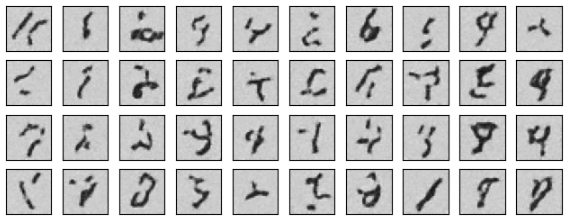

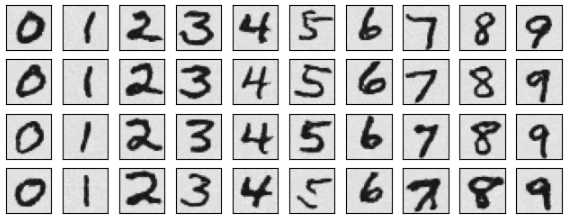



In this homework, you will implement a Diffusion Model for Conditional Image Generation on [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), leveraging concepts from recent advancements in generative modeling. Diffusion models are a powerful class of probabilistic models that iteratively denoise data sampled from Gaussian noise. These models have shown exceptional capabilities in generating high-quality images, as described in the foundational work ["Denoising Diffusion Probabilistic Models" (DDPM)](https://arxiv.org/abs/2006.11239).

To enhance the model's flexibility and control over generation, we incorporate ideas from ["Classifier-Free Diffusion Guidance"](https://arxiv.org/abs/2207.12598), allowing the model to condition its outputs on auxiliary information, such as class labels, without requiring an explicit classifier. This approach enables more efficient and accurate generation by combining guided and unguided diffusion in a unified framework.

This technique also features prominently in state-of-the-art models such as [Imagen](https://arxiv.org/abs/2205.11487), a photorealistic text-to-image diffusion model that demonstrates the power of conditioning on textual inputs for complex image generation tasks.


Your goal in this homework is to:

1. Implement a Contextual U-Net for conditional image generation, which incorporates class labels as additional context.
2. Use a Diffusion Model (DDPM) to iteratively denoise samples conditioned on class labels from the MNIST dataset.

Let’s dive into building this exciting model step-by-step!


In [25]:
# Import necessary libraries
import os
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

The Contextual U-Net is an enhanced version of the traditional U-Net architecture, specifically designed to integrate contextual information directly into its processing pipeline. This adaptation makes it particularly well-suited for tasks where auxiliary data—such as class labels, time steps, or other conditional inputs. By embedding context into both the encoding and decoding stages, the architecture achieves applications like conditional image generation and denoising diffusion models. Code cells below will guide you through the implementation. Please finish the following TODOs.

In [26]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False):
        """
        Residual Convolutional Block:
        - This block can either add a residual connection (ResNet style) or act as a standard convolutional block.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            is_res (bool): Whether to use a residual connection.
        """
        super().__init__()
        self.same_channels = in_channels == out_channels  # Check if input and output channels are the same
        self.is_res = is_res  # Store whether to use a residual connection

        # TODO: Define two convolutional layers with batch normalization and GELU activation.
        # - nn.Conv2d creates a 2D convolution layer.
        # - kernel_size=3 means the convolution uses a 3x3 filter.
        # - stride=1 keeps the spatial resolution the same.
        # - padding=1 ensures output has the same spatial size as input.
        # self.conv1 = None  # First convolutional layer
        # self.conv2 = None  # Second convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the block:
        - If is_res is True, add the residual connection to the output.
        - Otherwise, return the output of the convolutional block.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor after applying the block.
        """
        if self.is_res:  # If residual connection is enabled
            # x1 = None  # TODO: Apply the first convolutional layer to the input
            # x2 = None  # TODO: Apply the second convolutional layer to the output of the first
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            # if self.same_channels:
            #     # TODO: Add the input (x) to the final output (x2) when channels are the same
            #     out = None
            # else:
            #     # TODO: Add only the first convolution output (x1) to the final output when channels differ
            #     out = None
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2

            # Scaling by sqrt(2) (approx 1.414) for stable gradient flow during backpropagation
            return out / 1.414
        else:  # No residual connection
            x1 = self.conv1(x)  # Apply the first convolutional layer
            x2 = self.conv2(x1)  # Apply the second convolutional layer
            return x2

In [27]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        U-Net Downsampling Block:
        - This block processes an input feature map and reduces its spatial dimensions (downscales it).
        - It uses a residual convolutional block for feature extraction and a max-pooling layer for downsampling.

        Args:
            in_channels (int): Number of input channels in the feature map.
            out_channels (int): Number of output channels in the feature map.
        """
        super(UnetDown, self).__init__()

        # TODO: Define the layers in this block:
        # 1. A ResidualConvBlock processes the feature map to extract features while keeping the same spatial resolution.
        # 2. nn.MaxPool2d(2) reduces the height and width by half (downsampling).
        # Use nn.Sequential to combine these operations into one model.
        # self.model = None  # Replace with a ResidualConvBlock followed by nn.MaxPool2d

        self.model = nn.Sequential(
            ResidualConvBlock(in_channels=in_channels, out_channels=out_channels, is_res=True),
            nn.MaxPool2d(2)
        )


    def forward(self, x):
        """
        Forward pass of the downsampling block:
        - Applies the feature extraction and downsampling operations sequentially.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Downsampled tensor of shape (batch_size, out_channels, height/2, width/2).
        """
        # TODO: Pass the input through the model (ResidualConvBlock + MaxPool2d).
        return self.model(x)


In [28]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        U-Net Upsampling Block:
        - This block processes a feature map and increases its spatial dimensions (upsamples it).
        - It uses transposed convolutions for upsampling and residual convolutional blocks for feature refinement.
        - It incorporates skip connections by concatenating features from the corresponding downsampling block.

        Args:
            in_channels (int): Number of input channels in the feature map.
            out_channels (int): Number of output channels in the feature map after processing.
        """
        super(UnetUp, self).__init__()

        # TODO: Define the upscaling operation:
        # 1. nn.ConvTranspose2d performs upsampling (opposite of nn.Conv2d). It doubles the spatial dimensions.
        # 2. ResidualConvBlock refines the upsampled feature map for better feature learning.
        # You may use two ResidualConvBlock layers for better processing.
        # self.model = None  # Replace with a ConvTranspose2d followed by ResidualConvBlock(s)

        # ConvTranspose2d
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2  # Doubles the spatial dimensions
        )
        self.res = nn.Sequential(
            ResidualConvBlock(out_channels, out_channels, is_res=True),
            ResidualConvBlock(out_channels, out_channels, is_res=True)
        )

        # self.res1 = ResidualConvBlock(out_channels, out_channels, is_res=True)
        # self.res2 = ResidualConvBlock(out_channels, out_channels, is_res=True)
        # self.model = ResidualConvBlock(out_channels, out_channels, is_res=True)
        # self.model = ResidualConvBlock(in_channels, out_channels, is_res=False)

    def forward(self, x, skip):
        """
        Forward pass of the upsampling block:
        - Concatenates the input feature map (x) with the skip connection feature map.
        - Processes the concatenated features through the upsampling layers.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
            skip (torch.Tensor): Skip connection tensor from the corresponding downsampling block.

        Returns:
            torch.Tensor: Upsampled tensor of shape (batch_size, out_channels, height*2, width*2).
        """
        # TODO: Concatenate x and skip along the channel dimension.
        # Pass the concatenated tensor through the model (upscaling and feature refinement layers).
        # print(f"shape of x = {x.shape}")
        # print(f"shape of skip = {skip.shape}")
        # x = self.up(x) # upsample the input
        x = torch.cat([x, skip], dim=1) # concat with skip connection along the channel dimension
        x = self.up(x)
        x = self.res(x)

        return x


In [38]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        """
        Fully Connected Embedding Layer:
        - This block projects an input tensor into a higher-dimensional embedding space using a simple feedforward neural network.
        - It is commonly used to embed auxiliary information such as time steps or class labels in diffusion models.

        Args:
            input_dim (int): Dimensionality of the input tensor (e.g., a scalar or one-hot vector).
            emb_dim (int): Dimensionality of the output embedding space.
        """
        super(EmbedFC, self).__init__()

        # TODO: Define the embedding layers:
        # 1. First nn.Linear layer maps input_dim to emb_dim.
        # 2. nn.GELU activation adds non-linearity.
        # 3. Second nn.Linear layer projects the result back to emb_dim.

        # self.model = None  # Replace with a sequential model containing two nn.Linear layers and nn.GELU
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, x):
        """
        Forward pass of the embedding layer:
        - Flattens the input tensor and projects it into the embedding space.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Embedded tensor of shape (batch_size, emb_dim).
        """
        # TODO: Flatten x before passing it through the layers.
        # Hint: Use x.view(-1, self.input_dim) to reshape the tensor.
        x = x.view(-1, self.input_dim)
        x = self.model(x)
        return x


In [39]:
# class ContextUnet(nn.Module):
#     def __init__(self, in_channels, n_feat=256, n_classes=10):
#         """
#         Context U-Net for Conditional Diffusion:
#         - Combines image features, context labels, and time step embeddings to generate denoised images.

#         Args:
#             in_channels (int): Number of input channels in the image (e.g., 1 for grayscale images).
#             n_feat (int): Number of base features for the U-Net architecture.
#             n_classes (int): Number of context classes (e.g., digits for MNIST: 10 classes).
#         """
#         super(ContextUnet, self).__init__()

#         # TODO: Define the initial convolutional block for feature extraction
#         # Hint: Use ResidualConvBlock with `in_channels` and `n_feat`
#         self.init_conv = ResidualConvBlock(in_channels, n_feat)

#         # TODO: Define downscaling blocks
#         # Hint: Use UnetDown with appropriate feature sizes
#         self.down1 = UnetDown(n_feat, n_feat)  # Downscale from `n_feat` to `n_feat`
#         self.down2 = UnetDown(n_feat, n_feat * 2)  # Downscale from `n_feat` to `2 * n_feat`

#         # Bottleneck to reduce the spatial dimensions to a compact vector
#         self.to_vec = nn.Sequential(
#             nn.AvgPool2d(kernel_size=7),  # Reduces height and width to 1x1
#             nn.GELU()
#         )

#         # TODO: Define upscaling blocks
#         # Hint: Use UnetUp with appropriate feature sizes
#         self.up0 = UnetUp(2 * n_feat, 2 * n_feat)  # Upscale from compact vector to `2 * n_feat`
#         self.up1 = UnetUp(4 * n_feat, n_feat)  # Upscale from `4 * n_feat` to `n_feat`
#         self.up2 = UnetUp(2 * n_feat, n_feat)  # Upscale from `2 * n_feat` to `n_feat`

#         # TODO: Define the final output block
#         # Hint: Use convolutional layers to map `2 * n_feat` back to `in_channels`
#         self.out = nn.Sequential(
#             nn.Conv2d(2 * n_feat, in_channels, kernel_size=3, padding=1)
#         )

#         # TODO: Define embedding layers for time and context
#         # Hint: Use EmbedFC to project time steps and context labels into embedding spaces
#         self.timeembed1 = EmbedFC(1, 2 * n_feat)  # Embeds time steps to `2 * n_feat`
#         self.timeembed2 = EmbedFC(1, n_feat)  # Embeds time steps to `n_feat`
#         self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)  # Embeds context to `2 * n_feat`
#         self.contextembed2 = EmbedFC(n_classes, n_feat)  # Embeds context to `n_feat`

#     def forward(self, x, c, t, context_mask):
#         """
#         Forward pass of the Context U-Net:
#         - Combines noisy input images, time step embeddings, and context labels.
#         - Processes through downscaling and upscaling paths with skip connections.

#         Args:
#             x (torch.Tensor): Noisy image input of shape (batch_size, in_channels, height, width).
#             c (torch.Tensor): Context labels (class indices) of shape (batch_size,).
#             t (torch.Tensor): Timestep scalar of shape (batch_size, 1).
#             context_mask (torch.Tensor): Mask indicating which samples to block context on.

#         Returns:
#             torch.Tensor: Denoised image of the same shape as the input `x`.
#         """
#         # --- Step 1: Initial Convolution and Downscaling ---
#         # TODO: Pass input through the initial convolution and downscaling layers
#         # Hint: Save intermediate outputs (down1, down2) for skip connections
#         down1 = self.down1(self.init_conv(x))
#         down2 = self.down2(down1)
#         hiddenvec = self.to_vec(down2) # Pass through bottleneck (self.to_vec)

#         # --- Step 2: Embed Context and Time ---
#         # TODO: Convert `c` to one-hot encoding and apply context masking
#         # Hint: Use `nn.functional.one_hot` to one-hot encode `c` and multiply with `context_mask`
#         c_onehot = F.one_hot(c, num_classes=self.contextembed1.model[0].in_features).float()  # Convert context labels to one-hot encoding
#         c_masked = c_onehot * context_mask.view(-1, 1)  # Apply context mask to one-hot encoded labels

#         # TODO: Generate time and context embeddings
#         # Hint: Use `self.timeembed1`, `self.timeembed2`, `self.contextembed1`, and `self.contextembed2`
#         cemb1 = self.contextembed1(c_masked)
#         cemb2 = self.contextembed2(c_masked)
#         temb1 = self.timeembed1(t)
#         temb2 = self.timeembed2(t)

#         # --- Step 3: Upscaling and Skip Connections ---
#         # TODO: Upscale and incorporate embeddings with skip connections
#         # Hint: Use the embedding values to modify the upscaled features
#         up1 = self.up0(hiddenvec, down2 + cemb1.unsqueeze(-1).unsqueeze(-1) + temb1.unsqueeze(-1).unsqueeze(-1))  # Initial upsampling
#         up2 = self.up1(up1, down1 + cemb2.unsqueeze(-1).unsqueeze(-1) + temb2.unsqueeze(-1).unsqueeze(-1))  # Combine with down2
#         up3 = self.up2(up2, self.init_conv(x)) # Combine with down1

#         # --- Step 4: Final Output Layer ---
#         # TODO: Combine upscaled features with initial input features
#         # Hint: Use `torch.cat` for concatenation along the channel dimension
#         out = self.out(torch.cat([up3, x], dim=1))

#         return out


In [40]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask))
        c = c * context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [41]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


In [42]:
# class DDPM(nn.Module):
#   def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
#       """
#       Initialize the DDPM class.

#       Args:
#           nn_model (nn.Module): The neural network used to predict noise.
#           betas (tuple): Range of beta values for diffusion schedules (e.g., (0.1, 0.2)).
#           n_T (int): Number of timesteps in the diffusion process.
#           device (torch.device): The device to run computations on (e.g., 'cuda' or 'cpu').
#           drop_prob (float): Probability of dropping the context during training.
#       """
#       super(DDPM, self).__init__()

#       # Store the neural network and move it to the specified device
#       self.nn_model = nn_model.to(device)

#       # TODO: Register diffusion schedule buffers
#       # Hint: Call `ddpm_schedules` to compute diffusion parameters (alphas, betas, etc.).
#       # Use `self.register_buffer(name, value)` to store precomputed tensors as part of the model.
#       beta1, beta2 = betas
#       schedules = ddpm_schedules(beta1, beta2, n_T)
#       self.register_buffer('alpha', schedules["alpha_t"])
#       self.register_buffer('alpha_bar', schedules["alphabar_t"])
#       self.register_buffer('sqrtab', schedules["sqrtab"])
#       self.register_buffer('sqrtmab', schedules["sqrtmab"])

#       # Store other parameters
#       self.n_T = n_T
#       self.device = device
#       self.drop_prob = drop_prob

#       # Define the loss function (mean squared error for noise prediction)
#       self.loss_mse = nn.MSELoss()

#   def forward(self, x, c):
#       """
#       Forward pass for training the DDPM model.

#       Args:
#           x (torch.Tensor): Input images (noisy data) of shape (batch_size, channels, height, width).
#           c (torch.Tensor): Context labels (e.g., MNIST class labels).

#       Returns:
#           torch.Tensor: The mean squared error (MSE) between predicted and actual noise.
#       """
#       # --- Step 1: Sample random timesteps ---
#       # TODO: Sample timesteps `t` uniformly from {1, ..., n_T}.
#       # Hint: Use `torch.randint` to generate random integers.
#       _ts = torch.randint(1, self.n_T + 1, (x.size(1),), device=self.device)  # Replace with uniform sampling

#       # --- Step 2: Generate random noise ---
#       # TODO: Create random Gaussian noise of the same shape as `x`.
#       # Hint: Use `torch.randn_like(x)`.
#       noise = torch.randn_like(x)

#       # --- Step 3: Apply the forward diffusion process ---
#       # TODO: Use the precomputed buffers `self.sqrtab` and `self.sqrtmab` to compute:
#       # x_t = sqrt(alphabar) * x_0 + sqrt(1 - alphabar) * noise
#     #   alphabar_t = self.sqrtab[_ts]
#     #   sqrt_one_minus_alphabar_t = self.sqrtmab[_ts]
#     #   x_t = alphabar_t * x + sqrt_one_minus_alphabar_t * noise
#       alphabar_t = self.sqrtab[_ts].unsqueeze(1).unsqueeze(2).unsqueeze(3)  # Expand to match x's shape
#       sqrt_one_minus_alphabar_t = self.sqrtmab[_ts].unsqueeze(1).unsqueeze(2).unsqueeze(3)  # Expand to match x's shape
#       x_t = alphabar_t * x + sqrt_one_minus_alphabar_t * noise

#       # --- Step 4: Apply context dropout ---
#       # TODO: Randomly drop context with probability `self.drop_prob`.
#       # Hint: Use `torch.bernoulli` to generate a mask for the context.
#       context_mask = torch.bernoulli(torch.full((x.size(0),), 1 - self.drop_prob, device=self.device))

#       # --- Step 5: Predict the noise and compute loss ---
#       # TODO: Pass the noisy input (`x_t`), context labels (`c`), normalized timestep (`_ts / self.n_T`),
#       # and context mask to `self.nn_model`. Compute the MSE loss between `noise` and the predicted noise.
#       predicted_noise = self.nn_model(x_t, c, _ts / self.n_T, context_mask)
#       loss = self.loss_mse(predicted_noise, noise)

#       return loss


#   def sample(self, n_sample, size, device, guide_w=0.0):
#     """
#     Generate samples by reversing the diffusion process.

#     Args:
#         n_sample (int): Number of samples to generate.
#         size (tuple): Shape of each sample (e.g., (channels, height, width)).
#         device (torch.device): Device for computation (e.g., 'cuda').
#         guide_w (float): Guidance scale for classifier-free guidance.

#     Returns:
#         torch.Tensor: The final denoised samples.
#         np.ndarray: Intermediate denoising steps for visualization.
#     """
#     # --- Step 1: Initialize random noise ---
#     # TODO: Sample initial noise from a standard normal distribution.
#     # Hint: Use `torch.randn` with shape `(n_sample, *size)`.
#     x_i = torch.randn(n_sample, *size, device=device)

#     # TODO: Generate context labels (e.g., MNIST digits) cycling through {0, ..., 9}.
#     # Hint: Use `torch.arange` and `torch.repeat`.
#     c_i = torch.arange(0, 10, device=device).repeat(n_sample // 10)

#     # TODO: Create a context mask where the second half of the batch has no context.
#     # Hint: Use `torch.zeros_like` and set context for the second half to 1.
#     context_mask = torch.zeros(n_sample, device=device)
#     context_mask[n_sample // 2:] = 1

#     # --- Step 2: Iteratively reverse the diffusion process ---
#     x_i_store = []  # To store intermediate steps for visualization
#     for i in range(self.n_T, 0, -1):
#         print(f'Sampling timestep {i}', end='\r')

#         # TODO: Prepare the timestep tensor `t_is` and repeat for the batch
#         t_is = torch.full((n_sample,), i, dtype=torch.long, device=device)

#         # TODO: Double the batch size for classifier-free guidance
#         # Hint: Repeat `x_i`, `t_is`, `c_i`, and `context_mask` along the batch dimension.
#         x_i = x_i.repeat(2, 1, 1, 1)
#         t_is = t_is.repeat(2)
#         c_i = c_i.repeat(2)
#         context_mask = context_mask.repeat(2)

#         # TODO: Sample noise `z` if not at the last step (t > 1)
#         # Hint: Use `torch.randn` for noise, or set to zero for the last step.
#         z = torch.randn_like(x_i) if i > 1 else torch.zeros_like(x_i)

#         # --- Step 3: Predict noise using the model ---
#         # TODO: Pass inputs through `self.nn_model` and split predictions into guided and unguided components.
#         eps = self.nn_model(x_i, c_i, t_is / self.n_T, context_mask)
#         eps1 = eps[:n_sample]  # Unguided predictions
#         eps2 = eps[n_sample:]  # Guided predictions
#         eps = eps1 + guide_w * (eps2 - eps1)  # Combine guided and unguided predictions using `guide_w`

#         # TODO: Update `x_i` using the reverse diffusion equation:
#         # x_{t-1} = (1/sqrt(alpha_t)) * (x_t - eps * beta_t/sqrt(1-alpha_bar_t)) + sqrt(beta_t) * z
#         alpha_t = self.alpha[i-1]
#         alpha_bar_t = self.alpha_bar[i-1]
#         beta_t = self.betas[i-1]
#         x_i = (1 / torch.sqrt(alpha_t)) * (x_i - eps * beta_t / torch.sqrt(1 - alpha_bar_t)) + torch.sqrt(beta_t) * z

#         # Store intermediate steps
#         if i % 20 == 0 or i == self.n_T or i < 8:
#             x_i_store.append(x_i.detach().cpu().numpy())

#     x_i_store = np.array(x_i_store)
#     return x_i, x_i_store


In [43]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


The following implement the training loop and the diffusion sampling processing. Please following the instructions to finish the TODOs.

In [44]:
def train_mnist():
    # Training and Sampling Parameters
    n_epoch = 10
    batch_size = 256
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 128 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = False
    save_dir = './data/diffusion_outputs/'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    os.makedirs(save_dir, exist_ok=True)
    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
    dataset = MNIST("./data", train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()
        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            # Generate 4 samples per class for visualization
            n_sample = 4 * n_classes

            # Loop through different guidance weights (ws_test)
            for w_i, w in enumerate(ws_test):  # `ws_test` is a list of guidance weights
                # TODO: Use the DDPM model to generate samples
                # Hint: Call `ddpm.sample()` with the number of samples, image shape, device, and guidance weight.
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device=device, guide_w=w)

                # Prepare real images for comparison
                x_real = torch.Tensor(x_gen.shape).to(device)

                # Loop through all classes to append real images corresponding to each class
                for k in range(n_classes):  # Iterate over all classes
                    for j in range(int(n_sample / n_classes)):  # Iterate over the number of samples per class
                        try:
                            # TODO: Find the index of a real image belonging to class `k`
                            # Hint: Use `(c == k).nonzero()` to locate indices of images with label `k`.
                            idx = (c == k).nonzero().item()
                        except:
                            idx = 0
                        # TODO: Add the selected real image to the corresponding location in `x_real`
                        # pass
                        x_real[j + k * int(n_sample / n_classes)] = x[idx]

                # Concatenate generated images and real images
                x_all = torch.cat([x_gen, x_real])

                # Create a grid of images for visualization
                grid = make_grid(x_all * -1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print(f'saved image at {save_dir}image_ep{ep}_w{w}.png')

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")

Run the following code, and you will see the generation results! You are expected to see clear generated digits at the end of the training.

In [45]:
import torch
torch.cuda.empty_cache()

epoch 0


loss: 0.0496: 100%|██████████| 235/235 [01:36<00:00,  2.43it/s]



saved image at ./data/diffusion_outputs/image_ep0_w0.0.png
saved image at ./data/diffusion_outputs/gif_ep0_w0.0.gif

saved image at ./data/diffusion_outputs/image_ep0_w0.5.png
saved image at ./data/diffusion_outputs/gif_ep0_w0.5.gif

saved image at ./data/diffusion_outputs/image_ep0_w2.0.png
saved image at ./data/diffusion_outputs/gif_ep0_w2.0.gif
epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss: 0.0386: 100%|██████████| 235/235 [01:37<00:00,  2.42it/s]



saved image at ./data/diffusion_outputs/image_ep1_w0.0.png

saved image at ./data/diffusion_outputs/image_ep1_w0.5.png

saved image at ./data/diffusion_outputs/image_ep1_w2.0.png
epoch 2


loss: 0.0359: 100%|██████████| 235/235 [01:40<00:00,  2.34it/s]



saved image at ./data/diffusion_outputs/image_ep2_w0.0.png

saved image at ./data/diffusion_outputs/image_ep2_w0.5.png

saved image at ./data/diffusion_outputs/image_ep2_w2.0.png
epoch 3


loss: 0.0325: 100%|██████████| 235/235 [01:40<00:00,  2.33it/s]



saved image at ./data/diffusion_outputs/image_ep3_w0.0.png

saved image at ./data/diffusion_outputs/image_ep3_w0.5.png

saved image at ./data/diffusion_outputs/image_ep3_w2.0.png
epoch 4


loss: 0.0315: 100%|██████████| 235/235 [01:41<00:00,  2.33it/s]



saved image at ./data/diffusion_outputs/image_ep4_w0.0.png

saved image at ./data/diffusion_outputs/image_ep4_w0.5.png

saved image at ./data/diffusion_outputs/image_ep4_w2.0.png
epoch 5


loss: 0.0308: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s]



saved image at ./data/diffusion_outputs/image_ep5_w0.0.png
saved image at ./data/diffusion_outputs/gif_ep5_w0.0.gif

saved image at ./data/diffusion_outputs/image_ep5_w0.5.png
saved image at ./data/diffusion_outputs/gif_ep5_w0.5.gif

saved image at ./data/diffusion_outputs/image_ep5_w2.0.png
saved image at ./data/diffusion_outputs/gif_ep5_w2.0.gif
epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss: 0.0307: 100%|██████████| 235/235 [01:37<00:00,  2.42it/s]



saved image at ./data/diffusion_outputs/image_ep6_w0.0.png

saved image at ./data/diffusion_outputs/image_ep6_w0.5.png

saved image at ./data/diffusion_outputs/image_ep6_w2.0.png
epoch 7


loss: 0.0286: 100%|██████████| 235/235 [01:40<00:00,  2.34it/s]



saved image at ./data/diffusion_outputs/image_ep7_w0.0.png

saved image at ./data/diffusion_outputs/image_ep7_w0.5.png

saved image at ./data/diffusion_outputs/image_ep7_w2.0.png
epoch 8


loss: 0.0292: 100%|██████████| 235/235 [01:40<00:00,  2.33it/s]



saved image at ./data/diffusion_outputs/image_ep8_w0.0.png

saved image at ./data/diffusion_outputs/image_ep8_w0.5.png

saved image at ./data/diffusion_outputs/image_ep8_w2.0.png
epoch 9


loss: 0.0288: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]



saved image at ./data/diffusion_outputs/image_ep9_w0.0.png
saved image at ./data/diffusion_outputs/gif_ep9_w0.0.gif

saved image at ./data/diffusion_outputs/image_ep9_w0.5.png
saved image at ./data/diffusion_outputs/gif_ep9_w0.5.gif

saved image at ./data/diffusion_outputs/image_ep9_w2.0.png
saved image at ./data/diffusion_outputs/gif_ep9_w2.0.gif


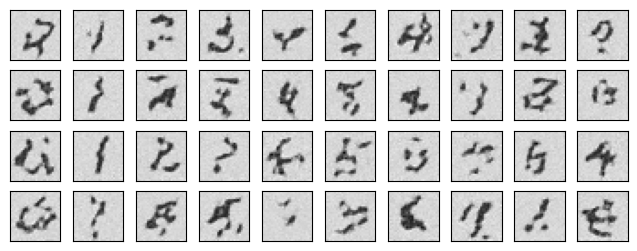

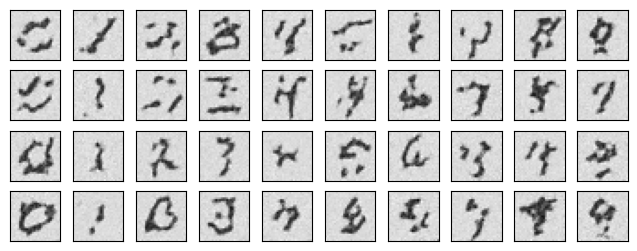

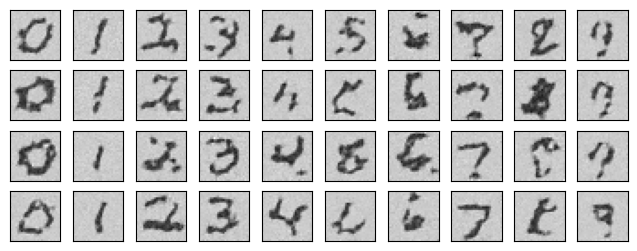

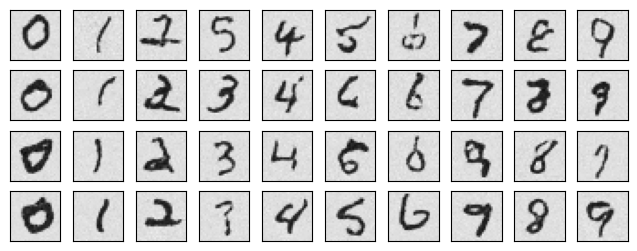

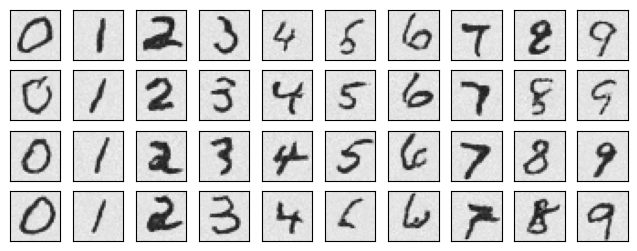

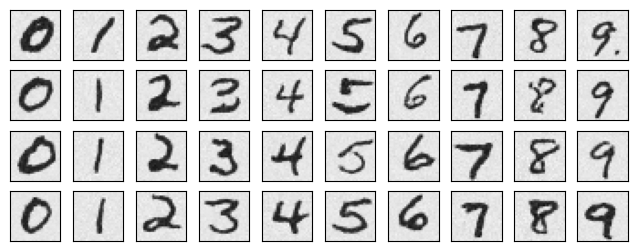

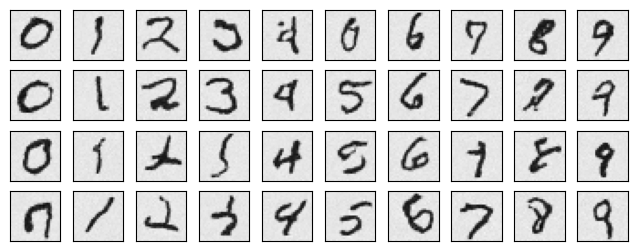

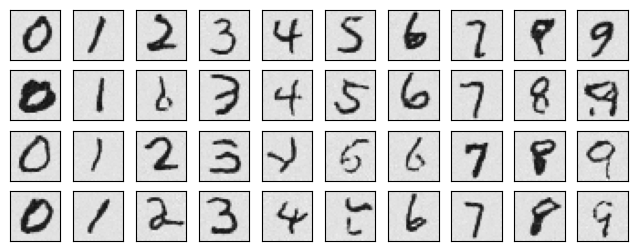

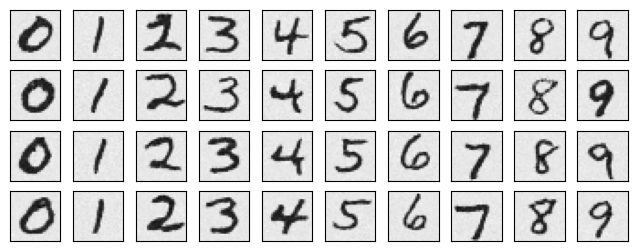

In [46]:
train_mnist()